# QAOA using Qiskit

In this notebook, we will show how to use QAOA to solve for the Max-Cut problem for the [$C_4$ graph](https://en.wikipedia.org/wiki/Cycle_graph). The main reference used is [https://qiskit.org/textbook/ch-applications/qaoa.html](https://qiskit.org/textbook/ch-applications/qaoa.html), but some re-work had to be done since the code in this reference were non-functioning at the time of writing.

Tested on `qiskit.__version`: `{'qiskit-terra': '0.19.1', 'qiskit-aer': '0.10.1', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.18.3', 'qiskit-aqua': None, 'qiskit': '0.34.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}` and `python --version`: `3.9.9` on Windows 11 x64.

In [1]:
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
import networkx as nx

For the $C_4$ graph, the problem Hamiltonian (associated with the edges of the graph) is:
$$H_P=\frac{1}{2}\left[(Z_0Z_1)+(Z_1Z_2)+(Z_2Z_3)+(Z_3Z_0)\right],$$
while the mixing Hamiltonian (associated with the vertices of the graph) is:
$$H_B=X_0+X_1+X_2+X_3.$$
Then, the unitaries associated with these Hamiltonians are as such:
$$U_P=\exp\left(-i\gamma H_P\right),\quad U_B=\exp\left(-i\beta H_B\right).$$

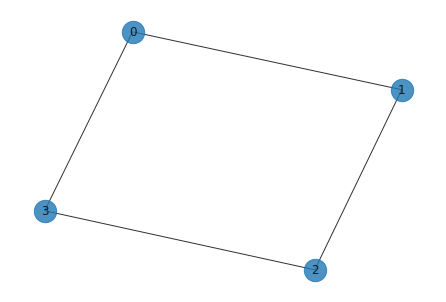

In [2]:
# Create the C_4 graph using networkx.
# Note that in the graph state representation of quantum states, the vertices represent qubits in the |+⟩ state while the edges represent controlled-Phase gates between the qubits.
nqubits = 4
qubits = [i for i in range(nqubits)]
G = nx.Graph()
G.add_nodes_from(qubits)
G.add_edges_from([(i,(i+1)%nqubits) for i in range(nqubits)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

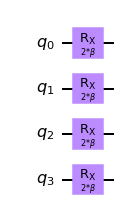

In [3]:
# Create the quantum circuit associated with the mixing Hamiltonian.
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
qc_mix.rx(2*beta,qubits)
qc_mix.draw("mpl")

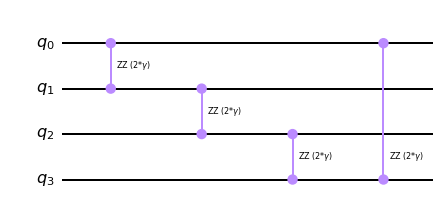

In [4]:
# Create the quantum circuit associated with the problem Hamiltonian.
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
qc_p.rzz(2*gamma,qubits,[(i+1)%nqubits for i in range(nqubits)])
qc_p.draw("mpl")

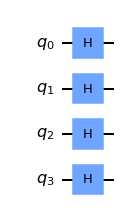

In [5]:
# Create the quantum circuit associated with the initialisation of the qubits.
qc_init = QuantumCircuit(nqubits)
qc_init.h(qubits)
qc_init.draw("mpl")

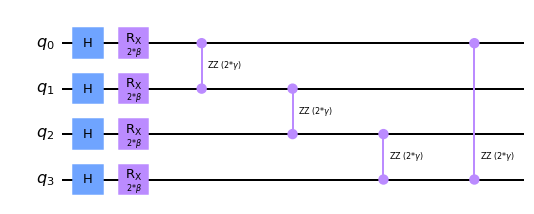

In [6]:
# Combine the components to form the QAOA circuit.
qc_QAOA = QuantumCircuit(nqubits)
qc_QAOA.append(qc_init,qubits)
qc_QAOA.append(qc_mix,qubits)
qc_QAOA.append(qc_p,qubits)
qc_QAOA.decompose().draw("mpl")

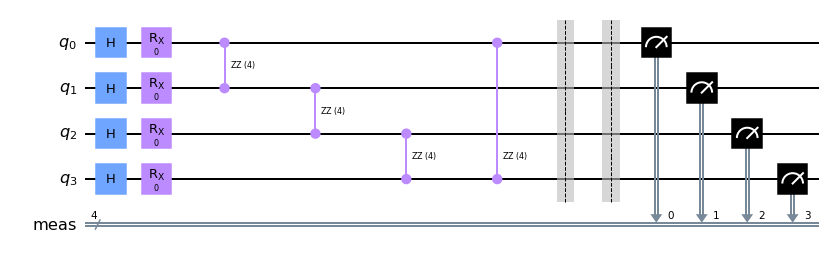

In [7]:
# Create a function that returns a QAOA circuit for arbitrary p (repetition of the problem and mixing Hamiltonians).
def generate_QAOA_circuit(p,theta):
    """
    Generates and returns a parametrised QAOA circuit for arbitrary p.

    Parameters
    ----------
    p: int
        Repetition of the problem and mixing subcircuits.
    theta: list
        List of the parameters beta and gamma.
    Returns
    -------
    qc: QuantumCircuit
        A QAOA circuit.
    """
    qc = QuantumCircuit(nqubits)
    qc_init = QuantumCircuit(nqubits)
    qc_mix = QuantumCircuit(nqubits)
    qc_p = QuantumCircuit(nqubits)

    qc_init.h(qubits)
    qc_mix.rx(2*theta[0],qubits)
    qc_p.rzz(2*theta[1],qubits,[(i+1)%nqubits for i in range(nqubits)])

    qc.append(qc_init,qubits)
    for i in range(p):
        qc.append(qc_mix,qubits)
        qc.append(qc_p,qubits)
        qc.barrier()
    qc.measure_all()
    return qc
qc = generate_QAOA_circuit(1,[0,2]) # test.
qc.decompose().draw("mpl")
    

In [8]:
# Write a function that calculates the number of edges shared between the partitions of the graph.
def maxcut_obj(x, G):
    """
    Given a bitstring x and a graph G, return the number of edges shared between the paritions of the graph (objective).

    Parameters
    ----------
    x: str
        Test solution bitstring.
    G: networkx.classes.graph.Graph
        Input graph state.
    Returns
    -------
    out: int
        Objective.
    """
    out = 0
    for i,j in G.edges():
        out -= 1*(x[i] != x[j]) # Negative because we want to minimise the expectation value.
    return out

# Write a function that calculate the expectation value of the maxcut objective.
def expectation_maxcut_obj(counts, G):
    """
    Given a graph G and the resulting occurrences of different bitstrings, calculate and return the expectation value of the maxcut objective.

    Parameters
    ----------
    counts: dict
        Key as bitstring, val as count as the corresponding bitstrings.
    G: networkx.classes.graph.Graph
        Input graph state.
    
    Returns
    -------
    out: float
        Expectation value of the maxcut objective.
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = maxcut_obj(bitstring, G)
        avg += obj*count
        sum_count += count
    out = avg/sum_count
    return out


In [9]:
def get_expectation(G, p , shots=512):
    backend = BasicAer.get_backend('qasm_simulator')
    def execute_circ(theta):
        qc = generate_QAOA_circuit(p, theta)
        counts = execute(qc,backend,shots=shots).result().get_counts()
        return expectation_maxcut_obj(counts, G)
    return execute_circ

In [10]:
# Minimise the expectation value of the maxcut objective using scipy's classical minimisation function.
p = 3
f_min = get_expectation(G, p=p) # function to minimise using a classical minisation technique.
theta_guess = [1.5, 0.5] # initial guess values for beta and gamma.
out = minimize(f_min, theta_guess, method='COBYLA')
print(f"{out}")

     fun: -3.95703125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([2.61991219, 0.52629871])


As expected, the bitstrings $1010$ and $0101$ are the most probable solutions since they return the highest number of edges shared between the partitions for the $C_4$ graph. This can be seen by plotting the result below from the scipy's classical minimisation.

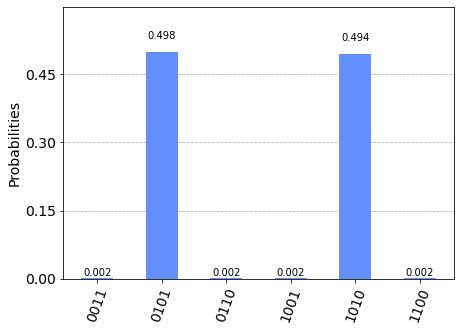

In [11]:
# Visualise the result from the classical minimisation.
backend = BasicAer.get_backend('qasm_simulator')

qc_res = generate_QAOA_circuit(p, out.x)

counts = execute(qc_res,backend,shots=512).result().get_counts()

plot_histogram(counts)